In [1]:
import os
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import cv2
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
def band_norm(temp):

    d_img = np.zeros([temp.shape[0], temp.shape[1], 3])

    for j in range(3):
        d_img[:, :, j] = ((temp[:, :, j] - np.min(temp[:, :, j])) /
                          (np.max(temp[:, :, j]) - np.min(temp[:, :, j])))

    d_img = np.uint8(d_img * 255)

    return d_img

In [3]:
def all_norm(temp):
    
    d_img = np.zeros([*temp.shape],'float16')

    d_img= (temp - np.min(temp)) / (np.max(temp) - np.min(temp))

    d_img = np.uint8(d_img * 255)

    return d_img

In [4]:
def truncated_linear_stretch(image, truncated_value, max_out = 255, min_out = 0):
    def gray_process(gray):
        truncated_down = np.percentile(gray, truncated_value)
        truncated_up = np.percentile(gray, 100 - truncated_value)
        gray_new = (gray - truncated_down) / (truncated_up - truncated_down) * (max_out - min_out) + min_out 
        gray_new[gray < truncated_down] = min_out
        gray_new[gray > truncated_up] = max_out
        if(max_out <= 255):
            gray_new = np.uint8(gray_new)
        elif(max_out <= 65535):
            gray_new = np.uint16(gray_new)
        return gray_new
    
    #  如果是多波段
    # if(len(image.shape) == 3):
    #     image_stretch = []
    #     for i in range(image.shape[-1]):
    #         gray = gray_process(image[:,:,i])
    #         image_stretch.append(gray)
    #     image_stretch = np.array(image_stretch).transpose(1,2,0)
    # #  如果是单波段
    # else:
    image_stretch = gray_process(image)
    return image_stretch

In [5]:
import hdf5storage as hdf5
YC_Compete = hdf5.loadmat('/home3/ywl/PycharmProject/CVSSN/data/YC_Compete/data_hsi.mat')

In [6]:
YC_Compete.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data'])

In [7]:
YC_Compete = YC_Compete['data']

In [8]:
YC_Compete.shape

(1175, 585, 253)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


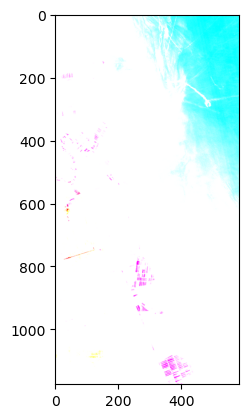

In [12]:
plt.imshow(YC_Compete[:,:,[80,40,10]])

In [13]:
print(np.min(YC_Compete),np.max(YC_Compete))

0 36933


In [14]:
YC_Compete_norm = all_norm(YC_Compete)

In [15]:
channel_num = 15

YC_Compete_data = np.zeros([*YC_Compete.shape[:2],channel_num])

bands = YC_Compete.shape[-1]//channel_num

for i in range(channel_num):
    end = min((i+1)*bands,YC_Compete.shape[-1])
    YC_Compete_data[:,:,i] = np.mean(YC_Compete[:,:,i*bands:end], axis=-1)

In [16]:
YC_Compete_data.shape

(1175, 585, 15)

In [17]:
for i in tqdm(range(YC_Compete_data.shape[-1]-2)):
    for j in range(i+1,YC_Compete_data.shape[-1]-1):
        for k in range(j+1,YC_Compete_data.shape[-1]):
            data = truncated_linear_stretch(YC_Compete_data[:,:,[k,j,i]],2)
            img = Image.fromarray(data)
            img.save(os.path.join(r'/home3/ywl/PycharmProject/CVSSN/data/YC_Compete/RGB',str(i+1)+'_'+str(j+1)+'_'+str(k+1)+'.png'))

100%|██████████| 13/13 [02:28<00:00, 11.41s/it]


In [1]:
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import hdf5storage as hdf5

def mirror_pad_and_crop(image, label, label_value, crop_size=512):
    """Mirror pad the image and crop regions corresponding to the given label value."""
    # Mirror pad the image and label
    pad_size = crop_size // 2  # Pad half the crop size
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='reflect')
    # padded_label = np.pad(label, ((pad_size, pad_size), (pad_size, pad_size)), mode='reflect')

    # Find positions of the given label value
    positions = np.argwhere(label == label_value)

    cropped_images = []
    for pos in positions:
        x, y = pos
        # Crop the image region
        cropped = padded_image[x: x + crop_size, y: y+crop_size, :]
        cropped_images.append(cropped)
    return cropped_images

# Load your train_label file (assumed to be a 2D array with labels per pixel)
train_label = hdf5.loadmat('/home3/ywl/PycharmProject/CVSSN/data/YC_Compete/train_label.mat')['train_label']  # Adjust the file format accordingly

# Path to your PNG images and output folder
image_dir = '/home3/ywl/PycharmProject/CVSSN/data/YC_Compete/RGB'
output_base_dir = '/home3/ywl/PycharmProject/CVSSN/data/YC_Compete'

print(train_label.shape)
print(len(np.unique(train_label)))
# Loop through the PNG files
for png_file in tqdm(os.listdir(image_dir)):
    if png_file.endswith('.png'):
        img_path = os.path.join(image_dir, png_file)
        image = np.array(Image.open(img_path))  # Load the image as a numpy array
        
        for label_value in np.unique(train_label):  # Loop over each label class
            if label_value != 0:
                cropped_images = mirror_pad_and_crop(image, train_label, label_value)
                
                # Create the class folder if it doesn't exist
                class_folder = os.path.join(output_base_dir, f'class_{label_value}')
                os.makedirs(class_folder, exist_ok=True)
    
                # Save cropped images
                for idx, cropped_image in enumerate(cropped_images):
                    cropped_img = Image.fromarray(cropped_image)
                    cropped_img.save(os.path.join(class_folder, f'{png_file}_crop_{idx}.jpg'))

print("Processing completed!")


(1175, 585)
19


100%|██████████| 455/455 [1:10:22<00:00,  9.28s/it]

Processing completed!


#### honghu

In [4]:
honghu_dict = scio.loadmat('/home2/lzn/project/DCN-T/data/Matlab_data_format/save/WHU_Hi_HongHu.mat')

In [5]:
honghu_dict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'WHU_Hi_HongHu'])

In [6]:
honghu_ori = honghu_dict['WHU_Hi_HongHu']

In [7]:
honghu_ori.shape

(940, 475, 270)

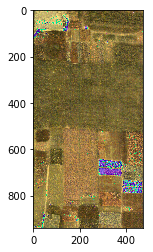

In [6]:
plt.imshow(honghu_ori[:,:,[50,30,10]])

In [7]:
print(np.min(honghu_ori),np.max(honghu_ori))

-0.15855066 6.1384525


##### all_norm

In [13]:
honghu_ori_norm = all_norm(honghu_ori)

MemoryError: Unable to allocate 460. MiB for an array with shape (940, 475, 270) and data type float32

In [8]:
channel_num = 15

honghu_data = np.zeros([*honghu_ori.shape[:2],channel_num])

bands = honghu_ori.shape[-1]//channel_num

for i in range(channel_num):
    end = min((i+1)*bands,honghu_ori.shape[-1])
    honghu_data[:,:,i] = np.mean(honghu_ori[:,:,i*bands:end], axis=-1)

In [9]:
honghu_data.shape

(940, 475, 15)

In [16]:
for i in tqdm(range(honghu_data.shape[-1]-2)):
    for j in range(i+1,honghu_data.shape[-1]-1):
        for k in range(j+1,honghu_data.shape[-1]):
            data = truncated_linear_stretch(honghu_data[:,:,[k,j,i]],2)
            img = Image.fromarray(data)
            img.save(os.path.join(r'D:\RS_CV\hyperspectral\Dataset\whuhi\honghu_15',str(i+1)+'_'+str(j+1)+'_'+str(k+1)+'.png'))

100%|██████████| 13/13 [05:29<00:00, 25.38s/it]


#### hanchuan

In [17]:
hanchuan_dict = scio.loadmat(r'F:\Move\RS_CV\Dataset\whuhi\Matlab_data_format\Matlab_data_format\WHU-Hi-HanChuan\WHU_Hi_HanChuan.mat')

In [18]:
hanchuan_ori = hanchuan_dict['WHU_Hi_HanChuan']

In [19]:
print(np.min(hanchuan_ori),np.max(hanchuan_ori))

0.0 22.46998


In [20]:
channel_num = 15

hanchuan_data = np.zeros([*hanchuan_ori.shape[:2],channel_num])

bands = hanchuan_ori.shape[-1]//channel_num

for i in range(channel_num):
    end = min((i+1)*bands,hanchuan_ori.shape[-1])
    hanchuan_data[:,:,i] = np.mean(hanchuan_ori[:,:,i*bands:end], axis=-1)

In [21]:
for i in tqdm(range(hanchuan_data.shape[-1]-2)):
    for j in range(i+1,hanchuan_data.shape[-1]-1):
        for k in range(j+1,hanchuan_data.shape[-1]):
            data = truncated_linear_stretch(hanchuan_data[:,:,[k,j,i]],2)
            img = Image.fromarray(data)
            img.save(os.path.join(r'D:\RS_CV\hyperspectral\Dataset\whuhi\hanchuan_15',str(i+1)+'_'+str(j+1)+'_'+str(k+1)+'.png'))

100%|██████████| 13/13 [07:03<00:00, 32.60s/it]


#### longkou

In [18]:
longkou_dict = scio.loadmat(r'F:\Move\RS_CV\Dataset\whuhi\Matlab_data_format\Matlab_data_format\WHU-Hi-LongKou\WHU_Hi_LongKou.mat')

In [19]:
longkou_ori = longkou_dict['WHU_Hi_LongKou']

In [20]:
print(np.min(longkou_ori),np.max(longkou_ori))

0.0 28.083261


In [21]:
channel_num = 15

longkou_data = np.zeros([*longkou_ori.shape[:2],channel_num])

bands = longkou_ori.shape[-1]//channel_num

for i in range(channel_num):
    end = min((i+1)*bands,longkou_ori.shape[-1])
    longkou_data[:,:,i] = np.mean(longkou_ori[:,:,i*bands:end], axis=-1)

In [38]:
for i in tqdm(range(longkou_data.shape[-1]-2)):
    for j in range(i+1,longkou_data.shape[-1]-1):
        for k in range(j+1,longkou_data.shape[-1]):
            data = truncated_linear_stretch(longkou_data[:,:,[k,j,i]],2)
            img = Image.fromarray(data)
            img.save(os.path.join(r'D:\RS_CV\hyperspectral\Dataset\whuhi\longkou_15',str(i+1)+'_'+str(j+1)+'_'+str(k+1)+'.png'))

100%|██████████| 13/13 [01:41<00:00,  7.78s/it]


#### vis feature

In [3]:
F = np.load('E:/RS_CV/DACT/dcnt_feature.npy')

In [5]:
F=F[0]

In [6]:
F.shape

(256, 137, 100)

In [13]:
mean_F = np.mean(F,axis=0)

In [16]:
sum_F = np.sum(F,axis=0)

In [33]:
mean_F = cv2.resize(mean_F, dsize=None, fx=4, fy=4, interpolation=cv2.INTER_LINEAR)

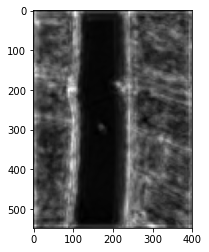

In [34]:
plt.imshow(mean_F,cmap='gray')

In [35]:
cv2.imwrite('F_vis.png',all_norm(mean_F))

True